## <a id='top'></a>

# CSCI 3202, Fall 2020
# Assignment 2
# Due: Friday 25 September 2020 by 11:59 PM

<br> 

### Your name: Kelley Kelley

<br> 

## Problem 1 (15 points)

Consider the directed state space graph below.

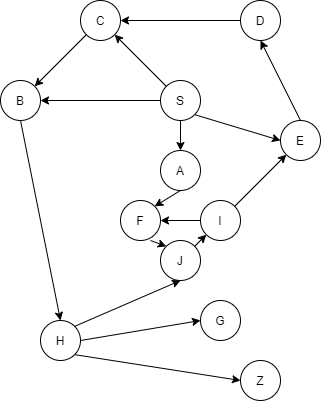

Suppose we wish to find the shortest edge-length path from the start node `S` to the goal node `G`.  Additionally, we have access to the heuristic of "straight line distance from the given node to `G`."


For each of the following search algorithms, what is the full route chosen from `S` to `G`?  For any algorithms that require an order by which to choose/queue equivalent nodes, assume that we open nodes alphabetically.

#### 1a) Breadth-First Search

$ S \rightarrow B \rightarrow H \rightarrow G $

#### 1b) Depth-First Search

$ S \rightarrow A \rightarrow F \rightarrow J \rightarrow I \rightarrow E \rightarrow D \rightarrow C \rightarrow B \rightarrow H \rightarrow G $

#### 1c) Greedy Best-First, with straight-line-distance heuristic


$S \rightarrow A \rightarrow F \rightarrow J \rightarrow I \rightarrow F \rightarrow J $ repeating $ I \rightarrow F \rightarrow J$

#### 1d) A$^*$, with straight-line-distance heuristic


$ S \rightarrow B \rightarrow H \rightarrow G $

#### 1e) Describe what properties of this graph may or may not have led to different paths from the algorithms above.

Some paths that move toward the goal in a straight line can't actually reach the goal without going all the way back to the beginning. Therefore just going straight toward the goal doesn't produce an optimal solution and causes you to need to go all the way around the graph. There's also a large number of nodes between the goal and the start in the straight line path which means if searching BFS you get to the goal much quicker since there are many less nodes on the path that isn't in a straight line toward the goal.



## Problem 2 (30 points)

### Escape from Chicago

It is the year 2030 and a freak earthquake has caused Chicago to break off from the mainland of Illinois. It has drifted out into Lake Michigan and is now used as a penal colony for the United States' worst criminals.  Snake Plisskin, world-famous tough guy and amateur sea lion enthusiast, must travel from Chicago to New York to find the antidote to the *Plutoxin 7 poison* that he and many other Chicagoans have been infected with.

Below are crude graphs, representing the northeastern United States.  The graph on the left, **map_distances**, represents the step costs between two states on the graph (cities) using the distance between the two cities along major highways.  On the right, **map_times** represents the step costs using estimated travel time (at 5 PM on a Friday, east coast time).  These graphs are defined in the helper routines at below.

If you take a look at those graphs, you will notice that for brevity's sake, we will use **lowercase** abbreviations for each city, consisting of the **first 3 letters** of the city's name.  So Providence is represented by the state 'pro', for example.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats

**map_distances**          |  **map_times**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 550px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1rI5w8CuWOS9reMIewc2IDBp_Z3pSUu1H" alt="Drawing" style="width: 550px;"/>

### Useful helper routines for searching

In [2]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [1]:
map_distances = dict(
    chi=dict(det=283, cle=345, ind=182),
    cle=dict(chi=345, det=169, col=144, pit=134, buf=189),
    ind=dict(chi=182, col=176),
    col=dict(ind=176, cle=144, pit=185),
    det=dict(chi=283, cle=169, buf=256),
    buf=dict(det=256, cle=189, pit=215, syr=150),
    pit=dict(col=185, cle=134, buf=215, phi=305, bal=247),
    syr=dict(buf=150, phi=253, new=254, bos=312),
    bal=dict(phi=101, pit=247),
    phi=dict(pit=305, bal=101, syr=253, new=97),
    new=dict(syr=254, phi=97, bos=215, pro=181),
    pro=dict(bos=50, new=181),
    bos=dict(pro=50, new=215, syr=312, por=107),
    por=dict(bos=107))

map_times = dict(
    chi=dict(det=280, cle=345, ind=200),
    cle=dict(chi=345, det=170, col=155, pit=145, buf=185),
    ind=dict(chi=200, col=175),
    col=dict(ind=175, cle=155, pit=185),
    det=dict(chi=280, cle=170, buf=270),
    buf=dict(det=270, cle=185, pit=215, syr=145),
    pit=dict(col=185, cle=145, buf=215, phi=305, bal=255),
    syr=dict(buf=145, phi=245, new=260, bos=290),
    bal=dict(phi=145, pit=255),
    phi=dict(pit=305, bal=145, syr=245, new=150),
    new=dict(syr=260, phi=150, bos=270, pro=260),
    pro=dict(bos=90, new=260),
    bos=dict(pro=90, new=270, syr=290, por=120),
    por=dict(bos=120))

sld_providence = dict(
    chi=833,
    cle=531,
    ind=782,
    col=618,
    det=596,
    buf=385,
    pit=458,
    syr=253,
    bal=325,
    phi=236,
    new=157,
    pro=0,
    bos=38,
    por=136)

print(map_distances)

def check_map(step_costs):
    ''' function to check if all the path costs are at least symmetric '''
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

{'chi': {'det': 283, 'cle': 345, 'ind': 182}, 'cle': {'chi': 345, 'det': 169, 'col': 144, 'pit': 134, 'buf': 189}, 'ind': {'chi': 182, 'col': 176}, 'col': {'ind': 176, 'cle': 144, 'pit': 185}, 'det': {'chi': 283, 'cle': 169, 'buf': 256}, 'buf': {'det': 256, 'cle': 189, 'pit': 215, 'syr': 150}, 'pit': {'col': 185, 'cle': 134, 'buf': 215, 'phi': 305, 'bal': 247}, 'syr': {'buf': 150, 'phi': 253, 'new': 254, 'bos': 312}, 'bal': {'phi': 101, 'pit': 247}, 'phi': {'pit': 305, 'bal': 101, 'syr': 253, 'new': 97}, 'new': {'syr': 254, 'phi': 97, 'bos': 215, 'pro': 181}, 'pro': {'bos': 50, 'new': 181}, 'bos': {'pro': 50, 'new': 215, 'syr': 312, 'por': 107}, 'por': {'bos': 107}}


<a id='p1a'></a>
### (2a)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using breadth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `map_distances`) along the list of states **path**

In [4]:
'''# few tests to make sure I remember how dictionaries work
print(map_distances['chi'])
print(map_distances['chi']['det'])
for i in map_distances['chi']:
    print(i, map_distances['chi'][i])
print(min(map_distances['chi'].values()))
'''
# path({'A':None, 'B':'A', 'C':'B'}, 'C') that took way too long to figure out and I don't get the point of it tbh
# holy crap path is fantastic and so nice woah, big brain
# while implementing BFS I realized how you use it :) so nice

# breadth first search implementation
def breadth_first(start, goal, state_graph, return_cost):
    if goal not in state_graph or start not in state_graph:
        return "Error"
    # this is a list of nodes we have explored
    explored = []
    # this is the list of paths we need to explore
    explore = [start]
    # this is a dictionary of how we get to nodes for passing to path method
    notpath = {start: None}
    # whether or not we have found the goal and need to keep looking
    goalfound = False
    # if the start is the goal then no need to do anything easy
    if start == goal:
        if return_cost:
            return ([start], 0)
        return [start]
    # while we haven't found the goal, go look for the goal 
    while not goalfound:
        # look at every node next to the node we need to explore next
        for node in state_graph[explore[0]]:
            # if we found the goal then set the while loop to stop, I prefer this over breaks because breaks usually break things (pun lol)
            if node == goal:
                goalfound = True
                notpath[node] = explore[0]
            # if it's not the goal then append it to our list to explore
            # since it appends it to the end of the list this will traverse in BFS manner
            # because the next level is being added at the end of explore, and we always get the first element of explore
            # which means each level won't be explored until the current level is explored
            # where level means how far away from the start we are in terms of just nodes
            elif node not in explored and node not in explore:
                explore.append(node)
                # we got to the next node so add it to our paths
                notpath[node] = explore[0]
        # add the node we just finished processing to our list of explored so it never gets processed again
        explored.append(explore[0])
        # remove it from the explore since we just finished exploring it
        explore.pop(0)
    # get the path from start to goal using the nice path function
    truepath = path(notpath, goal)
    # if we don't need to return the path cost then just return the path
    if not return_cost:
        return truepath
    # if we do need to return the path cost then create a tuple and use the nice pathcost function to get pathcost
    return (truepath, pathcost(truepath, state_graph))

In [5]:
# testing BFS bc that's the smart thing to do
print(breadth_first('chi', 'chi', map_distances, False))
print(breadth_first('chi', 'chi', map_distances, True))
# those passed yay, now time for level 2
print(breadth_first('chi', 'det', map_distances, False))
print(breadth_first('chi', 'det', map_distances, True))
# after some slight idk how to name variables issues and mixing them up, it actually works yay
# well, it worked for two so it should work in general cool
print(breadth_first('chi', 'pit', map_distances, True))
# only a minor issue and it's fixed yay cool
print(breadth_first('chi', 'phi', map_distances, True))
print(breadth_first('por', 'col', map_distances, True))
# ah, so good
# some edge cases just in case
print(breadth_first('my mother said to', 'and you are not it', map_distances, True))
print(breadth_first('chi', 'det', {'ha':'there is no chi or det'}, True))
print(breadth_first('', '', {}, True))
# interesting, done on my 70th run, that's a lot more than I thought

['chi']
(['chi'], 0)
['chi', 'det']
(['chi', 'det'], 283)
(['chi', 'cle', 'pit'], 479)
(['chi', 'cle', 'pit', 'phi'], 784)
(['por', 'bos', 'new', 'phi', 'pit', 'col'], 909)
Error
Error
Error


<a id='p1b'></a>
### (2b)

#### Depth-first search

Implement a function **depth_first(start, goal, state_graph, return_cost)** to search the state space (and step costs) defined by **state_graph** using depth-first search:
* **start**: initial state (e.g., 'ind')
* **end**: goal state (e.g., 'bos')
* **state_graph**: the dictionary defining the step costs (e.g., `map_distances`)
* **return_cost**: logical input representing whether or not to return the solution path cost
    * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
    * If **False**, then the only output is the solution path list object

In [6]:
# same thing as BFS except we are going to explore then end of explore instead of the beginning
def depth_first(start, goal, state_graph, return_cost):
    # error checking
    if goal not in state_graph or start not in state_graph:
        return "Error"
    # this is a list of nodes we have explored
    explored = []
    # this is the list of paths we need to explore
    explore = [start]
    # this is a dictionary of how we get to nodes for passing to path method
    notpath = {start: None}
    # whether or not we have found the goal and need to keep looking
    goalfound = False
    # if the start is the goal then no need to do anything easy
    if start == goal:
        if return_cost:
            return ([start], 0)
        return [start]
    # while we haven't found the goal, go look for the goal 
    while not goalfound:
        # BFS did this last but here we do it first bc DFS gets end of list and creates problems otherwise
        # get the last element and save it
        exploreboy = explore.pop()
        # append what we are exploring to explored
        explored.append(exploreboy)
        # look at every node next to the node we need to explore next
        for node in state_graph[exploreboy]:
            # if we found the goal then set the while loop to stop, I prefer this over breaks because breaks usually break things (pun lol)
            if node == goal:
                goalfound = True
                notpath[node] = exploreboy
            # if it's not the goal then append it to our list to explore
            # since it appends it to the end of the list this will traverse in DFS manner
            # because the next level is being added at the end of explore, and we always get the last element of explore
            elif node not in explored and node not in explore:
                explore.append(node)
                # we got to the next node so add it to our paths
                notpath[node] = exploreboy
    # get the path from start to goal using the nice path function
    truepath = path(notpath, goal)
    # if we don't need to return the path cost then just return the path
    if not return_cost:
        return truepath
    # if we do need to return the path cost then create a tuple and use the nice pathcost function to get pathcost
    return (truepath, pathcost(truepath, state_graph))

In [7]:
# testing DFS bc that's the smart thing to do
print(depth_first('chi', 'chi', map_distances, False))
print(depth_first('chi', 'chi', map_distances, True))
# those passed yay, now time for level 2
print(depth_first('chi', 'det', map_distances, False))
print(depth_first('chi', 'det', map_distances, True))
# after some slight idk how to name variables issues and mixing them up, it actually works yay
# well, it worked for two so it should work in general cool
print(depth_first('chi', 'pit', map_distances, True))
# only a minor issue and it's fixed yay cool
print(depth_first('chi', 'phi', map_distances, True))
print(depth_first('por', 'col', map_distances, True))
# ah, so good
# some edge cases just in case
print(depth_first('my mother said to', 'and you are not it', map_distances, True))
print(depth_first('chi', 'det', {'ha':'there is no chi or det'}, True))
print(depth_first('', '', {}, True))

['chi']
(['chi'], 0)
['chi', 'det']
(['chi', 'det'], 283)
(['chi', 'ind', 'col', 'pit'], 543)
(['chi', 'ind', 'col', 'pit', 'phi'], 848)
(['por', 'bos', 'syr', 'phi', 'pit', 'col'], 1162)
Error
Error
Error


<a id='p1c'></a>
### (2c)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the `heapq` package is imported in the helpers at the bottom of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** is the initial state (e.g., **start**='chi')
  * **cost** is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states**: maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q**: a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. I only suggest to code it in this way because I think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [8]:
class Frontier_PQ:
    
    # initialize states and q in the frontier class
    # states are explored q is the sorted list of current possible paths
    def __init__(self, start, cost):
        self.states = {start:cost}
        self.q = []
    
    # add a possible path to our sorted heap / the frontier
    def add(self, state, cost):
        heapq.heappush(self.q, (cost, state))
    
    # move from our frontier to our explored and return the lowest element
    # from our frontier
    def pop(self):
        lowest = heapq.heappop(self.q)
        self.states[lowest[1]] = lowest[0]
        return lowest
    
    # replace a frontier path with a better path
    # I also return True or False because this will make
    # UCS easier 
    def replace(self, state, cost):
        for i in range(0, len(self.q)):
            if self.q[i][1] == state:
                # make sure the path is actually better
                if self.q[i][0] > cost:
                    self.q[i] = (cost, state)
                    heapq.heapify(self.q)
                    return True
                else:
                    return False
    
    # just a helper function for testing frontier class
    def test(self):
        print(self.states, self.q)
    

In [9]:
''' me figuring out how to use heaps
heaptest = []
heapq.heappush(heaptest, (122, 'hello'))
print(heaptest)
heapq.heappush(heaptest, (18, 'hey'))
print(heaptest)
for i in range(0, len(heaptest)):
    print(heaptest[i])
    if heaptest[i][1] == 'hey':
        heaptest[i] = (200, 'hey')
        heapq.heapify(heaptest)
        break
print(heaptest)
'''
# testing our frontier_PQ class
frontier = Frontier_PQ('the start', 0)
frontier.test()
frontier.add('hello', 20)
frontier.add('world', 10)
frontier.test()
frontier.replace('world', 15)
frontier.test()
print(frontier.pop())
frontier.test()

{'the start': 0} []
{'the start': 0} [(10, 'world'), (20, 'hello')]
{'the start': 0} [(10, 'world'), (20, 'hello')]
(10, 'world')
{'the start': 0, 'world': 10} [(20, 'hello')]


Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **map_distances** or **map_times** below)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [10]:
def uniform_cost(start, goal, state_graph, return_cost):
    # error checking
    if goal not in state_graph or start not in state_graph:
        return "Error"
    # if our goal is where we started then easy
    if start == goal:
        if return_cost:
            return ([start], 0)
        return [start]
    # initialize our frontier
    frontier = Frontier_PQ(start, 0)
    # initialize our paths
    notpath = {start:None}
    # get all the nodes next to the start and put them into the frontier
    for node in state_graph[start]:
        frontier.add(node, pathcost([start, node], state_graph))
        notpath[node] = start
    # keep going until we return
    while True:
        #frontier.test()
        #print('paths:', notpath, '--------------')
        # get the lowest cost path
        node_tuple = frontier.pop()
        #print(node_tuple)
        # if it was our goal then we have made it return the stuff
        if node_tuple[1] == goal:
            truepath = path(notpath, goal)
            if return_cost:
                return (truepath, frontier.states[goal])
            return truepath
        # add all the new possible nodes to the frontier if we haven't already explored them
        for node in state_graph[node_tuple[1]]:
            #print(node)
            # if we've already found the shortest path to our node then skip it
            if not node in frontier.states:
                # now we check if the node already has a path and needs to be replaced or added
                if not node in notpath:
                    # it didn't exist yet so add it to our frontier
                    frontier.add(node, node_tuple[0] + pathcost([node_tuple[1], node], state_graph))
                    # also add how we got there to notpath
                    notpath[node] = node_tuple[1]
                # if it did already exist then we need to replace instead
                # this is why I added a return to replace, this just sends every possibility to replace
                # if it was actually better then replace will return True and therefore
                # we need to update notpath because this path was better, otherwise do nothing since 
                # this path was worse
                elif frontier.replace(node, node_tuple[0] + pathcost([node_tuple[1], node], state_graph)):
                    notpath[node] = node_tuple[1]

In [11]:
# time to test UC
print(uniform_cost('chi', 'chi', map_distances, False))
print(uniform_cost('chi', 'chi', map_distances, True))
# those passed yay, now time for level 2
print(uniform_cost('chi', 'det', map_distances, False))
print(uniform_cost('chi', 'det', map_distances, True))
# after some slight idk how to name variables issues and mixing them up, it actually works yay
# well, it worked for two so it should work in general cool
print(uniform_cost('chi', 'pit', map_distances, True))
# only a minor issue and it's fixed yay cool
print(uniform_cost('chi', 'phi', map_distances, True))
print(uniform_cost('por', 'col', map_distances, True))
# ah, so good
# some edge cases just in case
print(uniform_cost('my mother said to', 'and you are not it', map_distances, True))
print(uniform_cost('chi', 'det', {'ha':'there is no chi or det'}, True))
print(uniform_cost('', '', {}, True))

['chi']
(['chi'], 0)
['chi', 'det']
(['chi', 'det'], 283)
(['chi', 'cle', 'pit'], 479)
(['chi', 'cle', 'pit', 'phi'], 784)
(['por', 'bos', 'syr', 'buf', 'cle', 'col'], 902)
Error
Error
Error


<a id='p1d'></a>
### (2d)

In the code cell below, use a few **print** statements to showcase the output of each of your three search algorithms defined above (in **1a**, **1b** and **1c**) to find routes for Snake to travel from Chicago to New York, with path costs defined by the distance between cities.

Then, in the markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path?
* Why does this not surprise you?

In [12]:
print('Bread First Search ------------------------------')

print('1:', breadth_first('chi', 'chi', map_distances, False))
print('2:', breadth_first('chi', 'chi', map_distances, True))

print('3:', breadth_first('chi', 'det', map_distances, False))
print('4:', breadth_first('chi', 'det', map_distances, True))

print('5:', breadth_first('chi', 'pit', map_distances, True))

print('6:', breadth_first('chi', 'phi', map_distances, True))
print('7:', breadth_first('por', 'col', map_distances, True))

print('8:', breadth_first('chi', 'new', map_distances, True))
print('9:', breadth_first('chi', 'new', map_times, True))

print('Depth First Search ------------------------------')

print('1:', depth_first('chi', 'chi', map_distances, False))

print('3:', depth_first('chi', 'det', map_distances, False))
print('4:', depth_first('chi', 'det', map_distances, True))

print('5:', depth_first('chi', 'pit', map_distances, True))

print('6:', depth_first('chi', 'phi', map_distances, True))
print('7:', depth_first('por', 'col', map_distances, True))

print('8:', depth_first('chi', 'new', map_distances, True))
print('9:', depth_first('chi', 'new', map_times, True))

print('Uniform Cost ------------------------------')

print('1:', uniform_cost('chi', 'chi', map_distances, False))
print('2:', uniform_cost('chi', 'chi', map_distances, True))

print('3:', uniform_cost('chi', 'det', map_distances, False))
print('4:', uniform_cost('chi', 'det', map_distances, True))

print('5:', uniform_cost('chi', 'pit', map_distances, True))

print('6:', uniform_cost('chi', 'phi', map_distances, True))
print('7:', uniform_cost('por', 'col', map_distances, True))

print('8:', uniform_cost('chi', 'new', map_distances, True))
print('9:', uniform_cost('chi', 'new', map_times, True))

Bread First Search ------------------------------
1: ['chi']
2: (['chi'], 0)
3: ['chi', 'det']
4: (['chi', 'det'], 283)
5: (['chi', 'cle', 'pit'], 479)
6: (['chi', 'cle', 'pit', 'phi'], 784)
7: (['por', 'bos', 'new', 'phi', 'pit', 'col'], 909)
8: (['chi', 'det', 'buf', 'syr', 'new'], 943)
9: (['chi', 'det', 'buf', 'syr', 'new'], 955)
Depth First Search ------------------------------
1: ['chi']
3: ['chi', 'det']
4: (['chi', 'det'], 283)
5: (['chi', 'ind', 'col', 'pit'], 543)
6: (['chi', 'ind', 'col', 'pit', 'phi'], 848)
7: (['por', 'bos', 'syr', 'phi', 'pit', 'col'], 1162)
8: (['chi', 'ind', 'col', 'pit', 'phi', 'new'], 945)
9: (['chi', 'ind', 'col', 'pit', 'phi', 'new'], 1015)
Uniform Cost ------------------------------
1: ['chi']
2: (['chi'], 0)
3: ['chi', 'det']
4: (['chi', 'det'], 283)
5: (['chi', 'cle', 'pit'], 479)
6: (['chi', 'cle', 'pit', 'phi'], 784)
7: (['por', 'bos', 'syr', 'buf', 'cle', 'col'], 902)
8: (['chi', 'cle', 'pit', 'phi', 'new'], 881)
9: (['chi', 'cle', 'buf', 'syr

Uniform Cost always produces the shortest path because it's algorithm is find the shortest possible path. BFS finds the shortest path for small depths simply because the goal is really close so it doesn't really matter what path you take, same with DFS. For some larger paths BFS performs ok since most paths in the map are actually about the same cost, therefore just going through the closest nodes kind of works, but DFS wanders a lot and is pretty terrible unless you start really close to your goal. I was actually a little surprised that DFS in 8 didn't take super long, but I guess it just got lucky with the order nodes were traversed and didn't do too terrible.

<a id='p1e'></a>
### (2e)

The Plutoxin 7 poison (which Snake has been infected with) will cause Snake's central nervous system to implode after exactly 1000 minutes.

Will any of the paths found in **(1d)** get Snake to New York alive?  Show your work! Snake's life hangs in the balance.

In [13]:
print(uniform_cost('chi', 'new', map_distances, False))
print(pathcost(uniform_cost('chi', 'new', map_distances, False), map_times))

['chi', 'cle', 'pit', 'phi', 'new']
945


If you plug the shortest distance path gotten from uniform cost into pathcost using time, you get 945 minutes so he can make it since that's less than 1000 minuts.

chi to cle to pit to phi to new = 345 + 145 + 305 + 150 = 945 so algorithm was right.

<a id='p1f'></a>
### (2f)

Since time is a factor, Snake ought to optimize his route from Chicago to New York to minimize the total time required. Because Snake is a renaissance man, he knows some pretty slick search algorithms.  But because he's infected with deadly poison, Snake just isn't up to the task of implementing them - his code is full of bugs and he keeps sneezing all over his monitor!  Let's help him out, shall we?

In the code cell below, find the shortest path from Chicago to New York as measured by total time taken, and display the result using a **print** statement

In the markdown cell below the code cell, write a couple of sentences:
* Why did you choose the search algorithm and state space graph that you chose?
* Would the solution path found by the other algorithms (the ones you didn't use in your function call) change if you tried to optimize based on time as opposed to distance (i.e., used **map_times** as opposed to **map_distances**)? Why or why not?
* **Most importantly:**  will Snake get to New York in time to receive the Plutoxin 7 antidote? This answer should be justified by your code output.

In [14]:
print(uniform_cost('chi', 'new', map_times, True))

(['chi', 'cle', 'buf', 'syr', 'new'], 935)


I chose uniform cost because we want to ensure that we get the optimal solution and the actual shortest path from Chicago to New York since lives are at stake. I chose map_times graph because that bases the shortest path off of time rather than distance and in this problem we are most concerned with time not the distance. Some paths did change probably because the shortest time isn't always the shortest distance and some paths that are longer take less time and some that are shorter take more time. Yes he will, 935 is less than 1000 so he will make it with 65 minutes to spare. 

## Problem 3 (25 points)

Well, it turns out Snake used the right algorithms and lived through his perilous trip to New York City.  He returned to Chicago, where he is living happily among the criminals, sea lions and criminal sea lions  But we want a sequel!

During Snake's time on the east coast, he came to realize that the soothing Atlantic Ocean air does wonders for his nerves. Living in the penal colony of Chicago is just so stressful! So he has decided to pack up and move to Providence, Rhode Island.

Because Snake has traveled across the country already, he has some prior knowledge regarding how far various cities along the way are from his final destination of Providence.  In particular, Snake maps out the **straight-line distance** from major cities to Providence. This information is displayed graphically below, on a tattoo on Kurt Russell's forearm (you can't prove that isn't true), and in the `sld_providence` dictionary in the [helper functions] at the top of this notebook.

Also note that because it doesn't make much sense to add estimated travel times and the straight-line distance, we will only be using the `map_distances` state space graph for this problem.

**map_distances**          |  **sld_providence**
:-------------------------:|:-------------------------:
<img src="http://drive.google.com/uc?export=view&id=1j6Kam3F7ET-aIzT-6KMxaW7D7r8WAOME" alt="Drawing" style="width: 500px;"/>  | <img src="http://drive.google.com/uc?export=view&id=1a8FNEG7apKkRX7VvpdMgmeYbqeNuOdwz" alt="Drawing" style="width: 500px;"/>


<a id='p1a'></a>
### (3a)

Modify your code for uniform-cost search from Problem 1 so that it provides optionally as output the number of nodes **expanded** in completing the search. 

Include a new optional logical (True/False) argument **return_nexp**, so your function calls to the new uniform cost search will look like: `uniform_cost(start, goal, state_graph, return_cost, return_nexp)`.
* If `return_nexp` is True, then the last output in the output tuple should be the number of nodes expanded.
* If `return_nexp` is False, then the code should behave exactly as it does in problem 2.

Then, verify that your revised codes are working by checking Snake's optimal route from Chicago to New York. Include the number of nodes expanded and the path cost (using `map_distances`).

In [15]:
def uniform_cost(start, goal, state_graph, return_cost, return_nexp):
    # error checking
    if goal not in state_graph or start not in state_graph:
        return "Error"
    # if our goal is where we started then easy
    if start == goal:
        if return_cost:
            if return_nexp:
                return ([start], 0, 0)
            return ([start], 0)
        if return_nexp:
            return ([start], 0)
        return [start]
    # initialize our frontier
    frontier = Frontier_PQ(start, 0)
    # initialize our paths
    notpath = {start:None}
    # get all the nodes next to the start and put them into the frontier
    for node in state_graph[start]:
        frontier.add(node, pathcost([start, node], state_graph))
        notpath[node] = start
    expanded = 1
    # keep going until we return
    while True:
        #frontier.test()
        #print('paths:', notpath, '--------------')
        # get the lowest cost path
        node_tuple = frontier.pop()
        #print(node_tuple)
        # how many nodes we've expanded
        expanded += 1
        #print(node_tuple)
        # if it was our goal then we have made it return the stuff
        if node_tuple[1] == goal:
            truepath = path(notpath, goal)
            if return_cost:
                if return_nexp:
                    return (truepath, frontier.states[goal], expanded)
                return (truepath, frontier.states[goal])
            if return_nexp:
                return (truepath, expanded)
            return truepath
        # add all the new possible nodes to the frontier if we haven't already explored them
        for node in state_graph[node_tuple[1]]:
            #print(node)
            # if we've already found the shortest path to our node then skip it
            if not node in frontier.states:
                # now we check if the node already has a path and needs to be replaced or added
                if not node in notpath:
                    # it didn't exist yet so add it to our frontier
                    frontier.add(node, node_tuple[0] + pathcost([node_tuple[1], node], state_graph))
                    # also add how we got there to notpath
                    notpath[node] = node_tuple[1]
                # if it did already exist then we need to replace instead
                # this is why I added a return to replace, this just sends every possibility to replace
                # if it was actually better then replace will return True and therefore
                # we need to update notpath because this path was better, otherwise do nothing since 
                # this path was worse
                elif frontier.replace(node, node_tuple[0] + pathcost([node_tuple[1], node], state_graph)):
                    notpath[node] = node_tuple[1]

In [16]:
# previous output 8: (['chi', 'cle', 'pit', 'phi', 'new'], 881)
print('8:', uniform_cost('chi', 'new', map_distances, True, True))
# so it works

8: (['chi', 'cle', 'pit', 'phi', 'new'], 881, 11)


### (3b)

#### Heuristic function

Define a function to take as an argument the `state` that Snake is in (city on our graphs), and return as output the value of the straight-line distance heuristic, between Snake's `state` and Providence.  Note that your function should be quite short, and amounts to looking up the proper value from the `sld_providence` dictionary defined in the [helper functions](#helper).  Call this function `heuristic_sld_providence`.


In [17]:
def heuristic_sld_providence(state):
    if not state in sld_providence:
        return 'error'
    return sld_providence[state]

In [18]:
print(heuristic_sld_providence('chi'))
print(heuristic_sld_providence('easy'))

833
error


### (3c)

#### Full-blown A\* search

We are finally ready to help Snake use his knowledge of straight-line distances from various cities to Providence to inform his path-finding from Chicago to Providence!

Modify your uniform-cost search codes from **(2a)** even further so that they now perform **A\* search**, using as the heuristic function the straight-line distance to Providence.

Provide `heuristic` as an additional argument, which should just be the function name to call within the A\* code. So your call to the A\* routine should look like:  `astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp)`.  (This kind of modular programming will make it much easier to swap in alternative heuristic functions later, and also helps to facilitate debugging if something goes wrong.)

In [19]:
# this is the UC we made for 3a except we add the heuristic to the cost
# whereever you see pathcost being called just also call heuristic and add it to the cost
def astar_search(start, goal, state_graph, heuristic, return_cost, return_nexp):
    # error checking
    if goal not in state_graph or start not in state_graph:
        return "Error"
    # if our goal is where we started then easy
    if start == goal:
        if return_cost:
            if return_nexp:
                return ([start], 0, 0)
            return ([start], 0)
        if return_nexp:
            return ([start], 0)
        return [start]
    # initialize our frontier
    frontier = Frontier_PQ(start, 0)
    # initialize our paths
    notpath = {start:None}
    # get all the nodes next to the start and put them into the frontier
    for node in state_graph[start]:
        frontier.add(node, pathcost([start, node], state_graph) + heuristic(node))
        notpath[node] = start
    expanded = 1
    # keep going until we return
    while True:
        #print('paths:', notpath, '--------------')
        # get the lowest cost path
        node_tuple = frontier.pop()
        #print(node_tuple)
        # how many nodes we've expanded
        expanded += 1
        #print(node_tuple)
        # if it was our goal then we have made it return the stuff
        if node_tuple[1] == goal:
            truepath = path(notpath, goal)
            if return_cost:
                if return_nexp:
                    return (truepath, pathcost(truepath, state_graph), expanded)
                return (truepath, frontier.states[goal])
            if return_nexp:
                return (truepath, expanded)
            return truepath
        # add all the new possible nodes to the frontier if we haven't already explored them
        for node in state_graph[node_tuple[1]]:
            #print(node)
            # if we've already found the shortest path to our node then skip it
            if not node in frontier.states:
                # now we check if the node already has a path and needs to be replaced or added
                if not node in notpath:
                    # it didn't exist yet so add it to our frontier
                    frontier.add(node, node_tuple[0] + pathcost([node_tuple[1], node], state_graph) + heuristic(node))
                    # also add how we got there to notpath
                    notpath[node] = node_tuple[1]
                # if it did already exist then we need to replace instead
                # this is why I added a return to replace, this just sends every possibility to replace
                # if it was actually better then replace will return True and therefore
                # we need to update notpath because this path was better, otherwise do nothing since 
                # this path was worse
                elif frontier.replace(node, node_tuple[0] + pathcost([node_tuple[1], node], state_graph) + heuristic(node)):
                    notpath[node] = node_tuple[1]

In [20]:
print(uniform_cost('det', 'pro', map_distances, True, True))
print(astar_search('det', 'pro', map_distances, heuristic_sld_providence, True, True))

(['det', 'buf', 'syr', 'bos', 'pro'], 768, 13)
(['det', 'buf', 'syr', 'bos', 'pro'], 768, 8)


### (3d)

Snake has already made it to Buffalo on his own, but he is growing weary.  There were ***so*** many sea lions along the way, and he had to stop and admire their grace and beauty.  Use your A\* search code from **(3c)** to help Snake find the optimal path **by distance traveled** the rest of the way to Providence.  Print to the screen the following:
1. the optimal path
2. the optimal path cost (miles traveled)
3. the number of states expanded during the A\* search

Additionally, show below how many states must be expanded to find the optimal path from Buffalo to Providence using the regular old uniform-cost search algorithm from **(3a)**.  Comment on the difference in states that must be explored by each algorithm.

**Sanity check:** No matter what your `start` and `goal` states are, how should the output from `astar_search` and `uniform_cost` search compare?

In [21]:
print('Astar')
answer_tuple = astar_search('buf', 'pro', map_distances, heuristic_sld_providence, True, True)
print('1.', answer_tuple[0])
print('2.', answer_tuple[1])
print('3.', answer_tuple[2])
print('Uniform Cost')
answer_tuple = uniform_cost('buf', 'pro', map_distances, True, True)
print('1.', answer_tuple[0])
print('2.', answer_tuple[1])
print('3.', answer_tuple[2])

Astar
1. ['buf', 'syr', 'bos', 'pro']
2. 512
3. 6
Uniform Cost
1. ['buf', 'syr', 'bos', 'pro']
2. 512
3. 12


Uniform Cost searches away from Providence going to detroit and cleveland and even chicago possibly, while astar only goes in the direction of providence and doesn't explore nodes that lead it away from the goal leading to many less nodes needing to be explored. 


## Problem 4 (30 points)

Consider this maze, where gray tiles represent walls and orange tiles represent open space where you can walk.

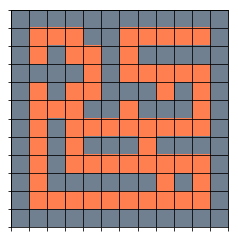

We can represent this maze using a binary `numpy` array as follows, where 1s represent walls and 0s represent open space:

In [22]:
maze = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
                 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1],
                 [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
                 [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
                 [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
                 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
                 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

**Very importantly**, note that the *first* row of the **maze** array corresponds to the *bottom* row of tiles in the figure.  This is a choice made carefully to reflect the fact that we are going to search for a solution path through this maze in *physical* space, so it is useful for our coordinate system to match Cartesian coordinates. This is in contrast to using the first row of the **maze** array to represent the top of the maze, which looks intuitive.

<a id='p3a'></a>
### (4a)

Write a function **maze_to_graph(maze)** that:
* takes as input a binary maze **maze**, stored as a `numpy` array, where 0 represents an open path and 1 represents a wall
* returns a graph dictionary in a similar style to **map_distances** and **map_times** (from Problem 1)
  * the keys are tuples giving the states (coordinate pairs) within the maze (e.g., (1,1) represents the lower-left open space, (2,1) represents the space **to the right** of (1,1), and (0,0) represents the lower-left corner, a wall location); thus, the coordinates within the maze are like Cartesian coordinates, and the x- and y-axes are the bottom and left walls of the maze, respectively
  * the values are themselves dictionaries, where the keys are other states within the maze and the values are the actions taken to move to that state
  * the actions are moves from the list ['N','S','E','W']

In [23]:
def maze_to_graph(maze):
    # the dictionary we are going to return
    graph_dict = {}
    for y in range(0, len(maze)):
        for x in range(0, len(maze[y])):
            if not maze[y][x]:
                actions = {}
                if y-1 >= 0 and not maze[y-1][x]:
                    actions[(x,y-1)] = 'S'
                if y+1 < len(maze) and not maze[y+1][x]:
                    actions[(x,y+1)] = 'N'
                if x-1 >= 0 and not maze[y][x-1]:
                    actions[(x-1,y)] = 'W'
                if x+1 < len(maze)and not maze[y][x+1]:
                    actions[(x+1,y)] = 'E'
                graph_dict[(x,y)] = actions
    return graph_dict
#maze_to_graph(maze)

<a id='p3b'></a>
### (4b)

Use your **maze_to_graph** function and **depth-first search** to solve the maze defined above.  A simple 'print' statement of the path your codes find and its length suffices.
* The initial state is (1,1)
* The goal state is (10,10)

Then, use your **breadth-first search** function to solve the maze; provide the solution path and its length.

If your codes are sufficiently general, the output from **maze_to_graph** should be suitable to be fed straight into your search routines.

In [24]:
maze_graph = maze_to_graph(maze)
depth_path = depth_first((1,1), (10,10), maze_graph, False)
breadth_path = breadth_first((1,1), (10,10), maze_graph, False)
print('DFS Path:', depth_path)
print('DFS length:', len(depth_path))
print('BFS Path:', breadth_path)
print('BFS length:', len(breadth_path))

DFS Path: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (10, 3), (9, 3), (8, 3), (7, 3), (6, 3), (5, 3), (4, 3), (3, 3), (3, 4), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)]
DFS length: 41
BFS Path: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (3, 6), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (10, 6), (10, 7), (10, 8), (9, 8), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)]
BFS length: 29


<a id='p3c'></a>
### (4c)

Write a function **plot_maze(maze, path)** that takes as input a binary `numpy` array **maze** (1s represent walls, 0s represent open space) and a solution **path**, and plots the two together.
* **maze**: a maze represented as a binary `numpy` array, as above
* **path**: a solution path found using your search algorithms above. **path** should be consistent with the output from the **path** function below in the helpers (a list of states).  You may find it useful to provide a default of `None` for **path**, so that you can use your function to just plot a maze that you haven't solved yet.

Then, use your **plot_maze** function to plot the maze defined above, along with the solution path found by **depth-first search**.  You may optionally include the breatdh-first solution as well, but make sure it's clear which path was the depth-first path.


<br>

**Potentially useful:** 

[1] In the helpers, you will notice that there are two packages imported:
  * `import matplotlib.pyplot as plt`
  * `from matplotlib import colors`

`pyplot` and `colors` may be potentially useful to you for generating a pretty plot and generating a colormap for your walls/open spaces in the maze, respectively.  You do not need to use them, but I wanted to provide this nudge for folks who maybe have not done much/any plotting in Python before.

[2] Also, [Color Oracle](http://colororacle.org/) is a useful utility for making colorblind-friendly plots. If you ever plan to show another human being a figure that you have generated, this is nice practice. Check it out!

In [25]:
def plot_maze(maze, path):
    # take everything from the path and set it's maze value to 2 so it plots it in a different color
    for cord in path:
        maze[cord[1]][cord[0]] = 2
    # the colors for our plot
    # wow, being colorblind sucks, it took forever to find something that worked
    cmap = colors.ListedColormap(['Cyan', 'Black', 'Magenta'])
    # I hated that if the path was empty then the background was red so fixed
    if len(path) == 0:
        cmap = colors.ListedColormap(['Cyan', 'Black'])
    # the plots size
    plt.figure(figsize=(6,6))
    # plot the maze
    plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=2)
    # actually show it
    plt.show()

Normal Maze


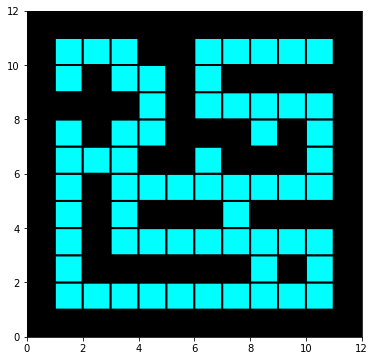

DFS Path


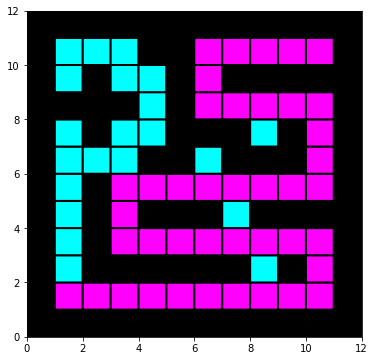

BFS Path


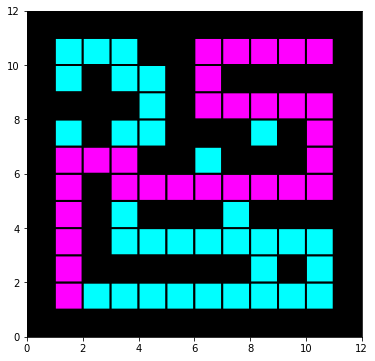

In [26]:
print('Normal Maze')
plot_maze(maze.copy(), [])

print('DFS Path')
plot_maze(maze.copy(), depth_path)

print('BFS Path')
plot_maze(maze.copy(), breadth_path)
# AH, finally done on iteration 286